# FACIES CLASSIFICATION IN WELL LOGS

## Introduction

This notebook examines a dataset related to faces classification in well logs. 
Facies represent different rock types and are essential for understanding subsurface geology and reservoir characterization. 
The primary objective is to create a machine learning model that can accurately predict facies based on well log data.
This dataset consists of labelled well log sdata from real wells in the Council gas reservoir, located in Southwest Kansas. 
The Panoma Council Grove Field is a carbonate gas reservoir covering 2700 square miles.


### Features in the dataset:
Each well log contains the following features:
**Gamma Ray(GR)** - Measures natural radioactivity of formations.

**Resistivity Logging(ILD_LOG10)** - Logs the electrical resistivity of rock formations.

**Photoelectric Effect(PE)** - Indicates mineral composition.

**Neutron-Density Porosity(DeltaPHI)** - Difference between neutron and density porosity.

**Average Neutron-Density Pororsity(PHID)** - Average neutron and density porosity.

**Nonmarine-Marine Indicator(NM_M)** - Distinguishes between marine and nonmarine environments.

**Relative Position(RELPOS)** - Represents the relative stratigraphic position within the reservoir.

The nine discrete facies (classes of rocks) are: 
1. __(SS)__   Nonmarine sandstone 
2. __(CSiS)__ Nonmarine coarse siltstone
3. __(FSiS)__ Nonmarine fine siltstone 
4. __(SiSH)__ Marine siltstone and shale 
5. __(MS)__   Mudstone (limestone) 
6. __(WS)__   Wackestone (limestone)
7. __(D)__    Dolomite
8. __(PS)__   Packstone-grainstone (limestone)
9. __(BS)__   Phylloid-algal bafflestone (limestone) 


Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

In [132]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [124]:
df = pd.read_csv("facies_vectors.csv")
df.head(10)

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   
5       3     A1 SH  SHRIMPLIN  2795.5  73.97      0.636      14.0  13.385   
6       3     A1 SH  SHRIMPLIN  2796.0  73.72      0.630      15.6  13.930   
7       3     A1 SH  SHRIMPLIN  2796.5  75.65      0.625      16.5  13.920   
8       3     A1 SH  SHRIMPLIN  2797.0  73.79      0.624      16.2  13.980   
9       3     A1 SH  SHRIMPLIN  2797.5  76.89      0.615      16.9  14.220   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915  
5  3.6     1   0.894  
6  3.7     1   0.872  
7  3.5     1   0.830  
8  3.4     1   0.809  
9  3.5     1   0.787

In [3]:
df.tail(10)

Facies Formation        Well Name   Depth      GR  ILD_log10  DeltaPHI  \
4139       5      C LM  CHURCHMAN BIBLE  3118.0  55.563      1.052     4.296   
4140       5      C LM  CHURCHMAN BIBLE  3118.5  58.313      1.034     3.863   
4141       5      C LM  CHURCHMAN BIBLE  3119.0  55.344      1.003     2.225   
4142       5      C LM  CHURCHMAN BIBLE  3119.5  53.313      0.972     1.640   
4143       5      C LM  CHURCHMAN BIBLE  3120.0  49.594      0.954     1.494   
4144       5      C LM  CHURCHMAN BIBLE  3120.5  46.719      0.947     1.828   
4145       5      C LM  CHURCHMAN BIBLE  3121.0  44.563      0.953     2.241   
4146       5      C LM  CHURCHMAN BIBLE  3121.5  49.719      0.964     2.925   
4147       5      C LM  CHURCHMAN BIBLE  3122.0  51.469      0.965     3.083   
4148       5      C LM  CHURCHMAN BIBLE  3122.5  50.031      0.970     2.609   

      PHIND     PE  NM_M  RELPOS  
4139  7.325  3.805     2   0.726  
4140  7.465  3.584     2   0.718  
4141  7.541  3.645     2   0.710  
4142  7.295  3.629     2   0.702  
4143  7.149  3.727     2   0.694  
4144  7.254  3.617     2   0.685  
4145  8.013  3.344     2   0.677  
4146  8.013  3.190     2   0.669  
4147  7.708  3.152     2   0.661  
4148  6.668  3.295     2   0.653

In [4]:
df.shape 

(4149, 11)

In [5]:
df.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

In [6]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


In [8]:
df["Facies"].value_counts()

Facies
2    940
3    780
8    686
6    582
5    296
4    271
1    268
9    185
7    141
Name: count, dtype: int64

In [9]:
df["Facies"].unique()

array([3, 2, 8, 6, 7, 4, 5, 9, 1], dtype=int64)

In [10]:
df["NM_M"].unique()

array([1, 2], dtype=int64)

In [11]:
facies_abbreviations ={
    1:"SS",
    2:"CSiS",
    3:"FSiS",
    4:"SiSH",
    5:"MS",
    6:"WS",
    7:"D",
    8:"PS",
    9:"BS"
}

facies_description = {
    1:"Nonmarine sandstone",
    2:"Nonmarine coarse siltstone",
    3:"Nonmarine fine siltstone",
    4:"Marine siltstone and shale",
    5:"Mudstone(limestone)",
    6:"Wackstone(limestone)",
    7:"Dolomite",
    8:"Packstone-grainstone(limestone)",
    9:"Phylloid-algal bafflestone(limestone)"
}

df["Facies_Description"] =df["Facies"].map(facies_description)
df["Facies_abbrivations"] = df["Facies"].map(facies_abbreviations)

df[["Facies_abbrivations"]]
#df.head()

Facies_abbrivations
0                   FSiS
1                   FSiS
2                   FSiS
3                   FSiS
4                   FSiS
...                  ...
4144                  MS
4145                  MS
4146                  MS
4147                  MS
4148                  MS

[4149 rows x 1 columns]

In [12]:
df[["Facies_Description"]]

Facies_Description
0     Nonmarine fine siltstone
1     Nonmarine fine siltstone
2     Nonmarine fine siltstone
3     Nonmarine fine siltstone
4     Nonmarine fine siltstone
...                        ...
4144       Mudstone(limestone)
4145       Mudstone(limestone)
4146       Mudstone(limestone)
4147       Mudstone(limestone)
4148       Mudstone(limestone)

[4149 rows x 1 columns]

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


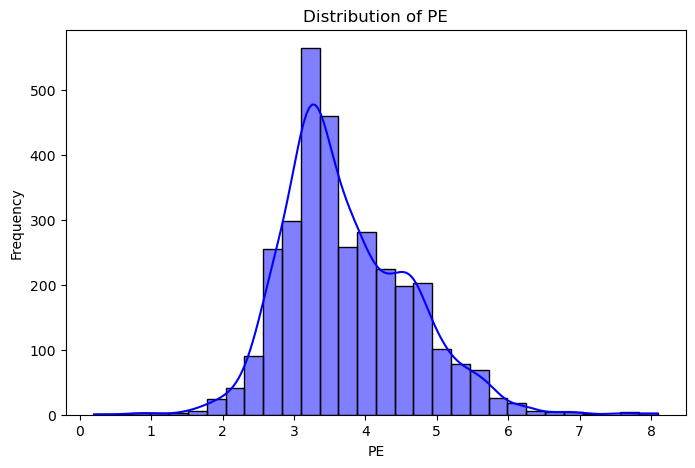

In [13]:
#Plot histogram of PE to check distribution.
plt.figure(figsize=(8, 5));
sns.histplot(df["PE"], bins=30, kde=True, color="blue");
plt.title("Distribution of PE");
plt.xlabel("PE");
plt.ylabel("Frequency");


In [14]:
# Imputing missing values PE category
df["PE"].fillna(df["PE"].mean(), inplace=True)

In [15]:
df.isnull().sum()

Facies                 0
Formation              0
Well Name              0
Depth                  0
GR                     0
ILD_log10              0
DeltaPHI               0
PHIND                  0
PE                     0
NM_M                   0
RELPOS                 0
Facies_Description     0
Facies_abbrivations    0
dtype: int64

In [16]:
df.duplicated().sum()

1

In [17]:
duplicates = df[df.duplicated()]
print("Duplicated row(s):")
print(duplicates)

#Drop the duplicated row
df = df.drop_duplicates()

print(f"Remaining duplicates: {df.duplicated().sum()}")

Duplicated row(s):
     Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI  PHIND  \
302       8     B5 LM  SHRIMPLIN  2944.0  234.8      0.515       4.7  11.41   

      PE  NM_M  RELPOS               Facies_Description Facies_abbrivations  
302  4.8     2     0.4  Packstone-grainstone(limestone)                  PS  
Remaining duplicates: 0


## Checking for outliers

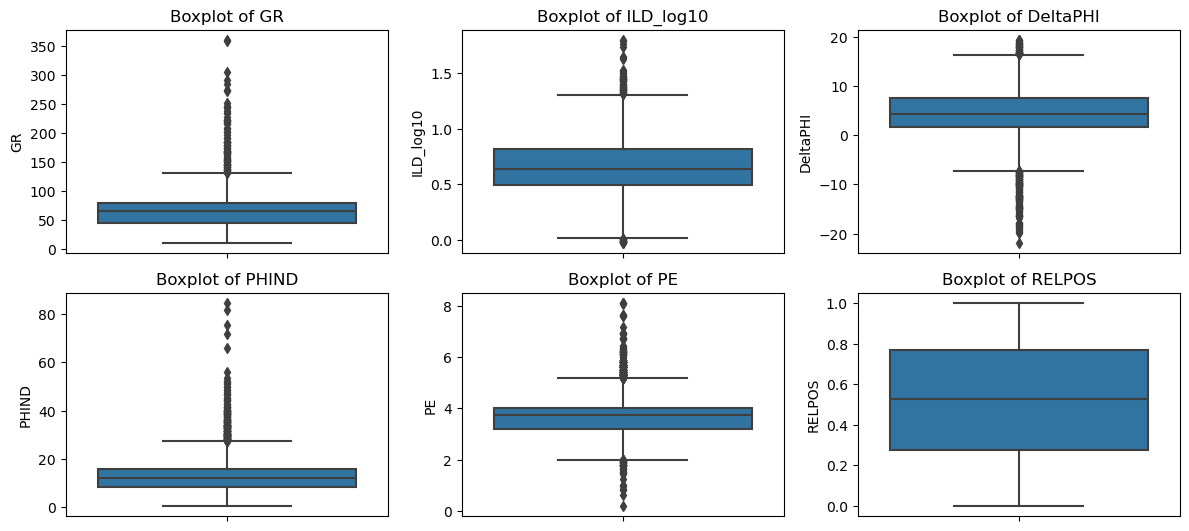

In [18]:
num_cols = ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "RELPOS"]

plt.figure(figsize=(12, 8));
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col]);
    plt.title(f"Boxplot of {col}");
plt.tight_layout();

In [19]:
 def detect_outliers_iqr(df, columns):
        outlier_indices = {}
        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q1 + 1.5 * IQR
            outlier_indices[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        return outlier_indices  
    
outlier = detect_outliers_iqr(df, num_cols)
outlier

{'GR': [38,
  70,
  71,
  72,
  94,
  95,
  96,
  109,
  153,
  159,
  160,
  161,
  199,
  220,
  259,
  260,
  261,
  262,
  263,
  279,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  301,
  303,
  304,
  305,
  309,
  310,
  311,
  312,
  313,
  314,
  345,
  346,
  347,
  414,
  415,
  416,
  417,
  418,
  419,
  444,
  522,
  523,
  524,
  525,
  538,
  539,
  540,
  541,
  542,
  635,
  636,
  637,
  638,
  639,
  640,
  641,
  642,
  671,
  672,
  673,
  674,
  675,
  734,
  735,
  769,
  770,
  771,
  772,
  773,
  774,
  775,
  809,
  810,
  811,
  812,
  813,
  814,
  815,
  816,
  817,
  818,
  819,
  820,
  821,
  875,
  876,
  877,
  878,
  879,
  880,
  881,
  882,
  883,
  884,
  902,
  903,
  904,
  905,
  913,
  914,
  915,
  916,
  917,
  937,
  938,
  939,
  1038,
  1039,
  1258,
  1259,
  1262,
  1263,
  1264,
  1265,
  1266,
  1362,
  1363,
  1364,
  1365,
  1366,
  1367,
  1368,
  1369,
  1370,
  1399,
  1400,
  1401,
  1402,
  1403,
  1404,
  1405,
  1461,
  

In [20]:
num_cols = ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "RELPOS"]
  

def impute_outliers_with_median(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        median_value = df[col].median()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])
   
    return df   

df = impute_outliers_with_median(df, num_cols)

df.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  4148.000000  4148.000000  4148.000000  4148.000000  4148.000000   
mean      4.502411  2906.858486    62.322793     0.652909     4.770159   
std       2.474026   133.314988    23.353035     0.234145     4.190731   
min       1.000000  2573.500000    10.149000     0.012000    -7.200000   
25%       2.000000  2821.500000    44.727250     0.500000     1.900000   
50%       4.000000  2932.500000    64.982500     0.639000     4.300000   
75%       6.000000  3007.000000    78.222500     0.811000     7.300000   
max       9.000000  3138.000000   130.950000     1.308000    16.341000   

             PHIND           PE         NM_M       RELPOS  
count  4148.000000  4148.000000  4148.000000  4148.000000  
mean     12.205012     3.642183     1.518322     0.521881  
std       4.937747     0.598419     0.499724     0.286673  
min       0.550000     2.004000     1.000000     0.000000  
25%       8.500000     3.235750     1.000000     0.277000  
50%      12.022500     3.725014     2.000000     0.528000  
75%      15.200000     3.830000     2.000000     0.769000  
max      27.272000     5.187000     2.000000     1.000000

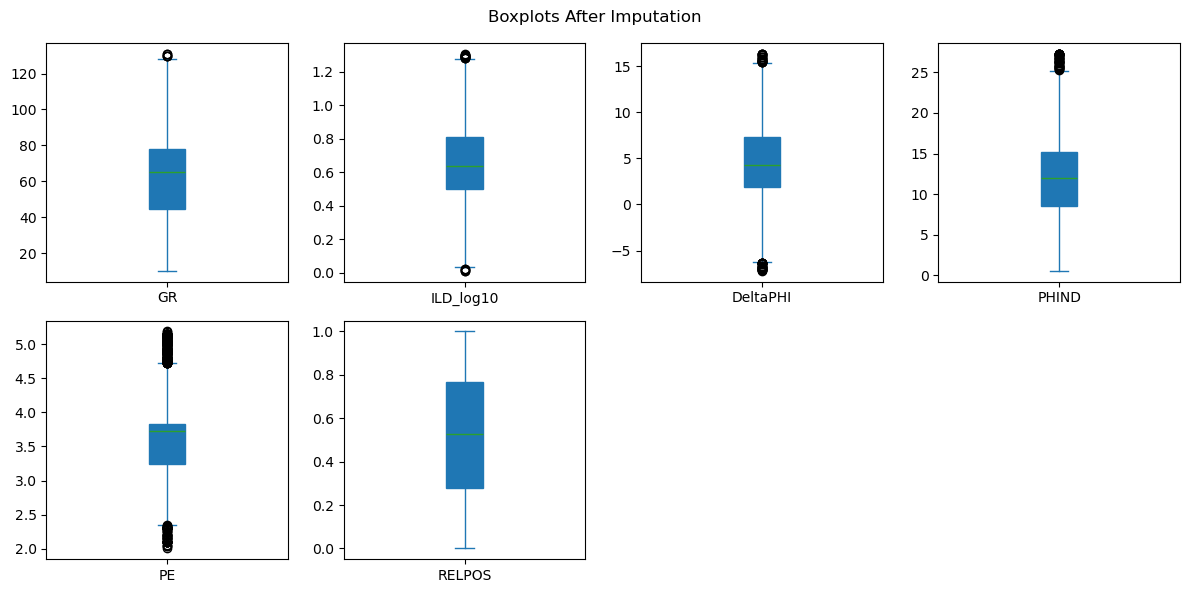

In [21]:
num_cols = ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "RELPOS"]
  

def impute_outliers_with_median(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = df[col].mask((df[col] < lower) | (df[col] > upper), df[col].median())

# Plot boxplots after imputation
df[num_cols].plot(kind="box", subplots=True, layout=(2, 4), figsize=(12,6), patch_artist=True);
plt.suptitle("Boxplots After Imputation");
plt.tight_layout();
    

# UNIVARIATE ANALYSIS
### Visualization of the Target Variable(Facies)

In [22]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Facies_Description',
       'Facies_abbrivations'],
      dtype='object')

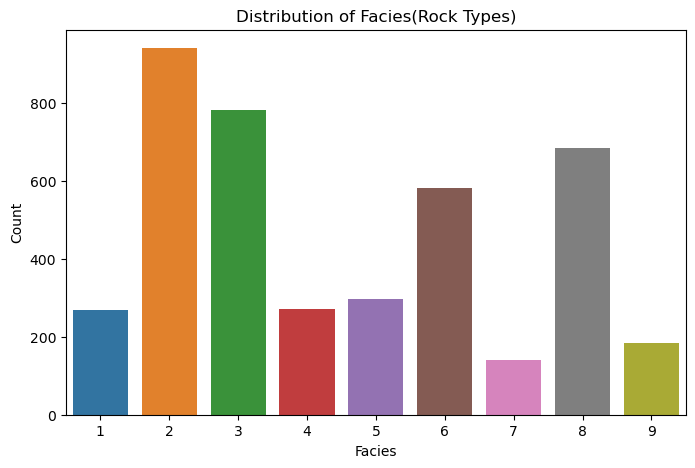

In [23]:
plt.figure(figsize=(8, 5));
sns.countplot(x= "Facies", data=df); 
sns.color_palette("viridis", n_colors=9);
plt.title("Distribution of Facies(Rock Types)");
plt.xlabel("Facies");
plt.ylabel("Count");

#### Observation
Facies 2(Nonmarine Coarse Siltstone) is the most abundant in the dataset, then Facies 3(Nonmarine Fine Siltstone) and Facies 8(Packstone-Grainstone)

Facies 7(Dolomite) and Facies 9(Phylloid-Algal Bafflestone) have the lowest occurences.

There is class imbalance where some facies types(2,3 & 8) dominate, while Facies 7 & 9 are underrepresented.

#### Geological Implications
##### Dominance of Facies 2 & 3
Indicates that nonmarine depositional environment were predominant in this region.

##### Low Occurrence of Facies 7 & 9
Dolomite and algal bafflestone are less common suggesting limited dolomitization on reef building condtions in the reservoir.

### Distribution of Numerical Features


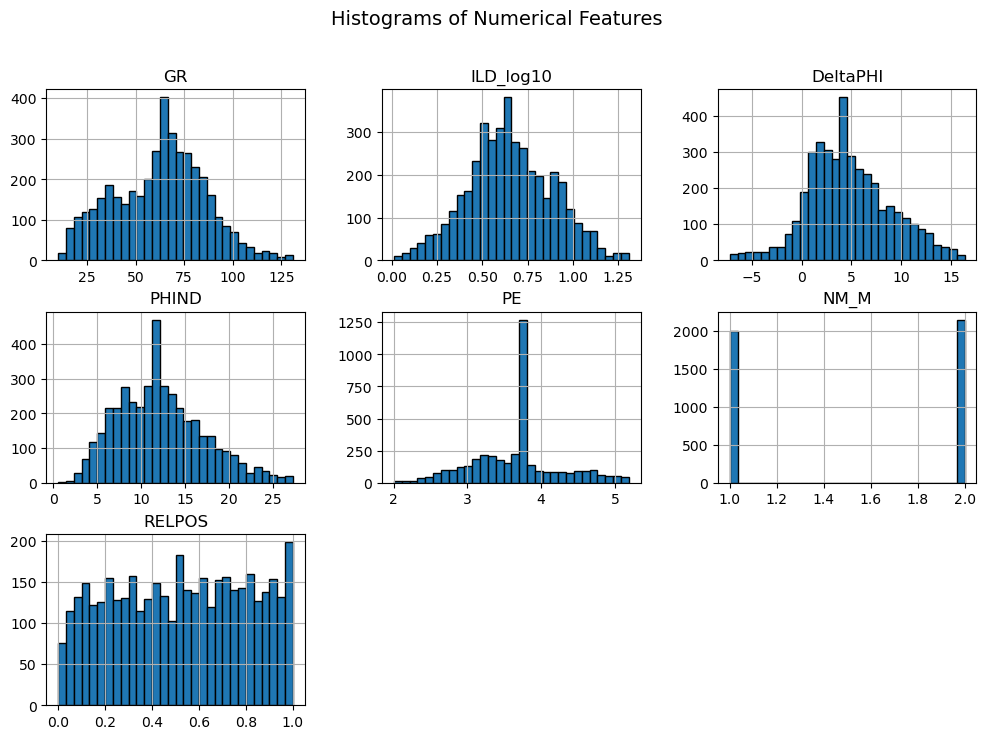

In [24]:
num_cols = ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M", "RELPOS"]

df[num_cols].hist(figsize=(12,8), bins=30, edgecolor="black");
plt.suptitle("Histograms of Numerical Features", fontsize=14);

### Observation and Interpretation

##### GR (Gamma Ray) Distribution
The distribution is right skewed(most values con

# 2.BIVARIATE ANALYSIS

In [25]:
df.dtypes

Facies                   int64
Formation               object
Well Name               object
Depth                  float64
GR                     float64
ILD_log10              float64
DeltaPHI               float64
PHIND                  float64
PE                     float64
NM_M                     int64
RELPOS                 float64
Facies_Description      object
Facies_abbrivations     object
dtype: object

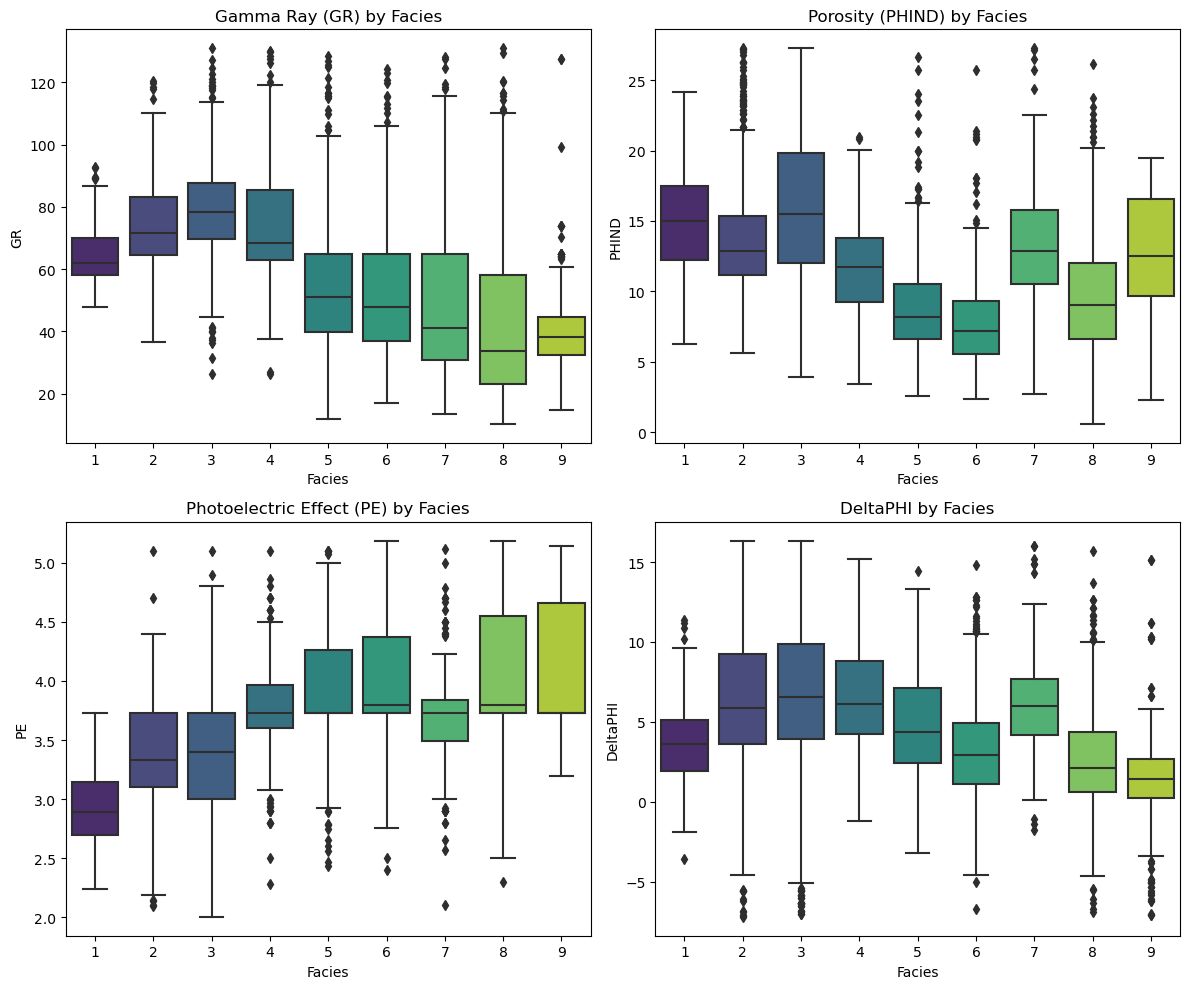

In [26]:
# Number of Unique facies 
n_facies = df["Facies"].nunique()
viridis_discrete = sns.color_palette("viridis", n_colors=n_facies)

fig, axes = plt.subplots(2, 2, figsize=(12,10));

sns.boxplot(x="Facies", y="GR", data=df, ax=axes[0,0], palette=viridis_discrete)
axes[0,0].set_title("Gamma Ray (GR) by Facies");

sns.boxplot(x="Facies", y="PHIND", data=df, ax=axes[0,1], palette=viridis_discrete)
axes[0,1].set_title("Porosity (PHIND) by Facies");

sns.boxplot(x="Facies", y="PE", data=df, ax=axes[1,0], palette=viridis_discrete)
axes[1,0].set_title("Photoelectric Effect (PE) by Facies");

sns.boxplot(x="Facies", y="DeltaPHI", data=df, ax=axes[1,1], palette=viridis_discrete)
axes[1,1].set_title("DeltaPHI by Facies");

plt.tight_layout()

# MULTIVARIATE ANALYSIS

### Pairplot for Feature Interactions

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

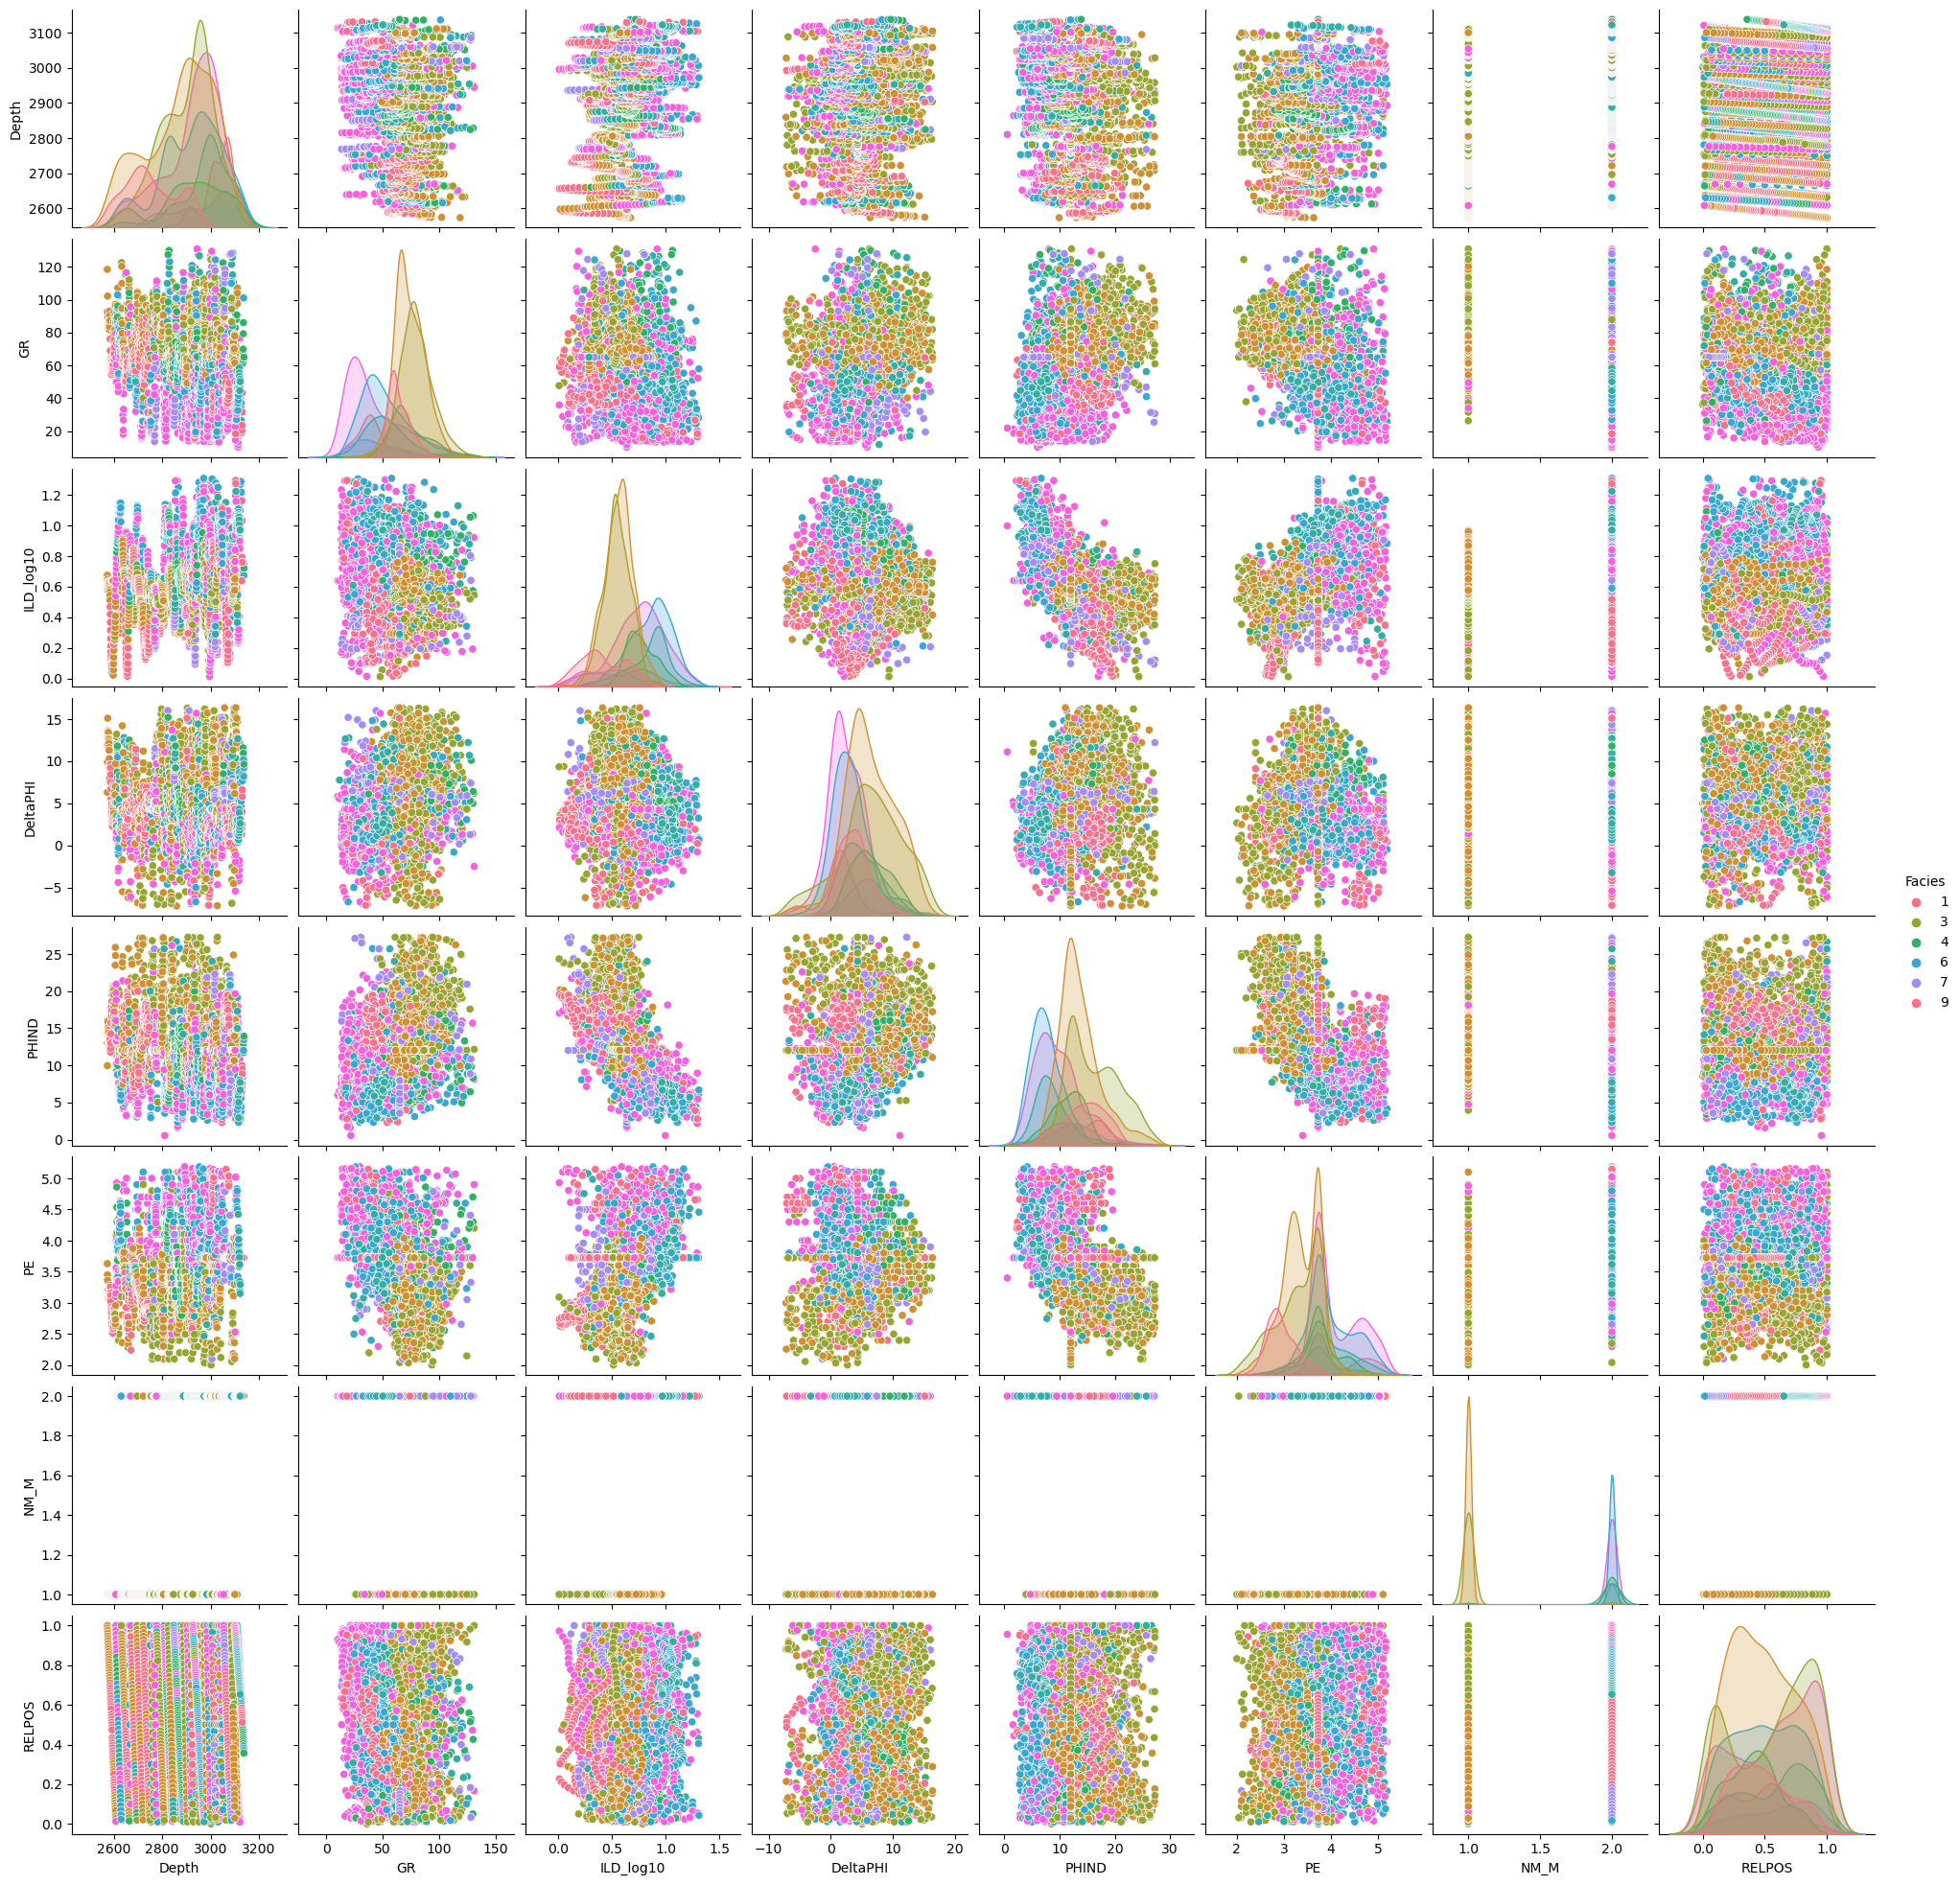

In [27]:
sns.pairplot(df, hue="Facies", diag_kind="kde", palette="husl");

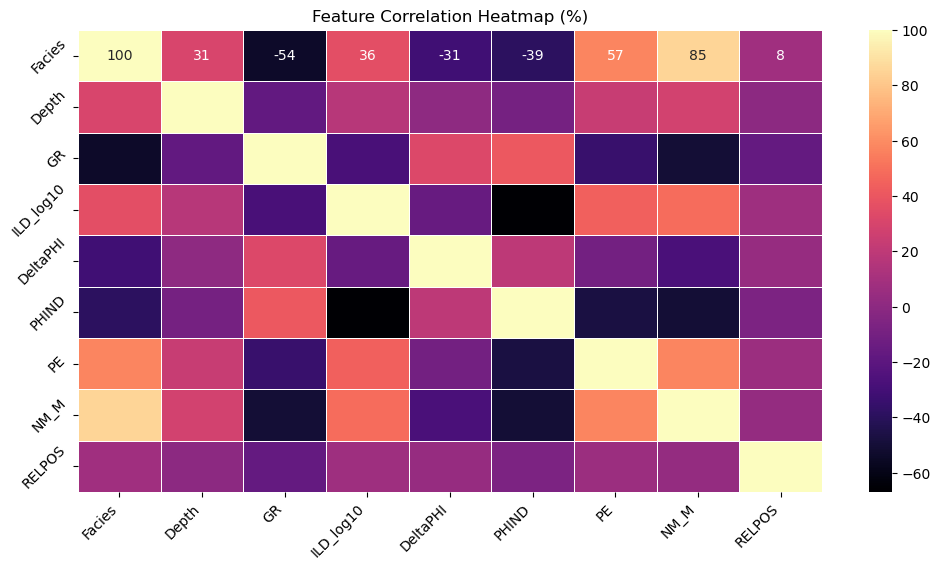

In [29]:
numeric_df = df.select_dtypes(include=["number"])

# Compute correlation matrix
corr_percentage = numeric_df.corr() * 100  # Convert to percentage

# Plot heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    corr_percentage, 
    annot=True, 
    cmap="magma", 
    linewidths=0.5, 
    fmt=".0f",  
    annot_kws={"size": 10}  
)

# Rotate labels for readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")

# Set title
plt.title("Feature Correlation Heatmap (%)")

plt.show()

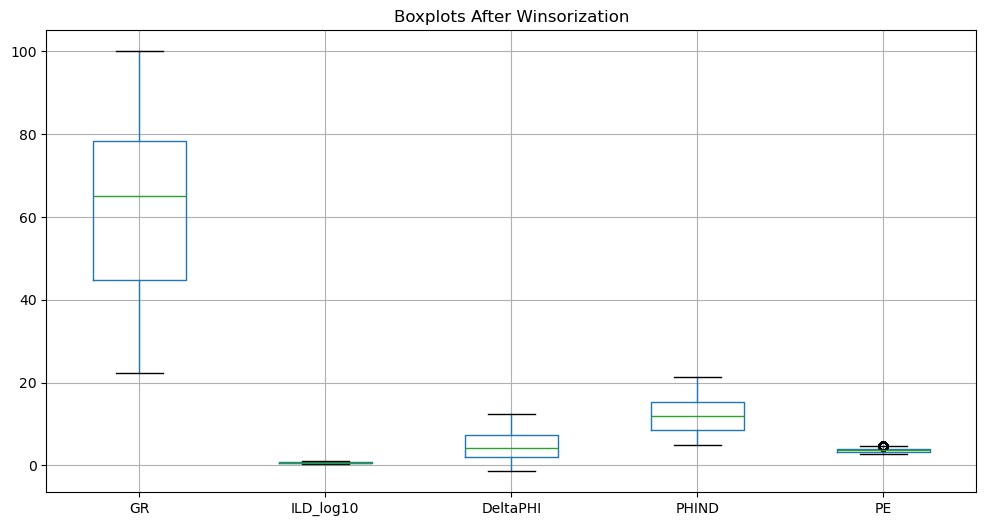

In [30]:
# Apply Winsorization to multiple columns (adjust limits as needed)
columns_to_winsorize = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']
for col in columns_to_winsorize:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])  # Caps 5% lowest & highest values

# Check boxplots after winsorization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df[columns_to_winsorize].boxplot()
plt.title("Boxplots After Winsorization")
plt.show()

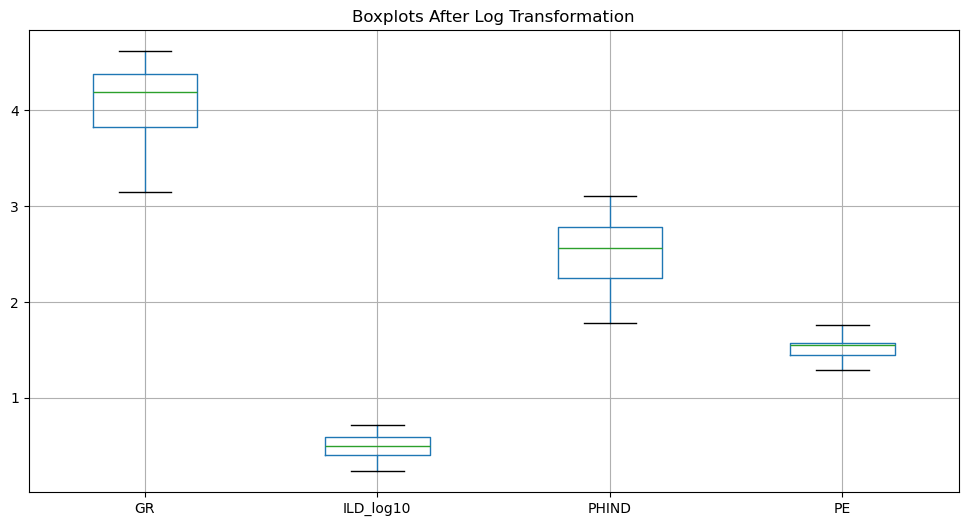

In [31]:
columns_to_log_transform = ["GR", "ILD_log10", "PHIND", "PE"]
for col in columns_to_log_transform:
    df[col] = np.log1p(df[col])
    
plt.figure(figsize=(12, 6));
df[columns_to_log_transform].boxplot();
plt.title("Boxplots After Log Transformation");


## Feature Engineering

In [32]:
# Step 1: Check for non-numeric columns
print(df.dtypes)

Facies                   int64
Formation               object
Well Name               object
Depth                  float64
GR                     float64
ILD_log10              float64
DeltaPHI               float64
PHIND                  float64
PE                     float64
NM_M                     int64
RELPOS                 float64
Facies_Description      object
Facies_abbrivations     object
dtype: object


##### Label encoding on categorical features

In [33]:
#Encoding categorical columns
categorical_cols = ["Formation", "Well Name"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [36]:
features_1 = ["Facies_Description", "Facies_abbrivations"]

## MODELING

### Spliting the dataset into training and testing sets

In [37]:
X = df.drop(columns=["Facies"] + features_1)
y = df["Facies"]

### Train- Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handling Class Imbalance using (SMOTE)

In [40]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [145]:
pd.concat([pd.DataFrame(X_train_smote, columns=X_train.columns),
          pd.Series(y_train_smote, name="Facies")], axis=1) \
  .to_csv("smote_training_data.csv", index=False)                  

### Feature Scaling

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


print("Class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())
print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

Class distribution after SMOTE:
 Facies
8    752
4    752
3    752
2    752
5    752
6    752
9    752
1    752
7    752
Name: count, dtype: int64
Train shape: (6768, 10), Test shape: (830, 10)


# MODEL TRAINING

## Logistic Regression Model

In [52]:
# Initializing and training model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [53]:
#Predictions
y_pred_log = log_reg.predict(X_test_scaled)

#Evaluation
print(f" Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Classification Report:\n", classification_report(y_test, y_pred_log))

 Logistic Regression Accuracy: 0.5325
Classification Report:
               precision    recall  f1-score   support

           1       0.45      0.83      0.58        54
           2       0.62      0.56      0.59       188
           3       0.61      0.51      0.56       156
           4       0.49      0.74      0.59        54
           5       0.38      0.44      0.41        59
           6       0.56      0.44      0.50       117
           7       0.38      0.50      0.43        28
           8       0.57      0.39      0.46       137
           9       0.48      0.73      0.58        37

    accuracy                           0.53       830
   macro avg       0.50      0.57      0.52       830
weighted avg       0.55      0.53      0.53       830



##### Performance Overview
The Logistic regression model achieved an accuracy of53.25% while it handles certain classes, Class 1 has a high recal pof 0.83. it struggles with others Class 8 with a recall of 0.39. 
The macro average F1 score of 0.52 suggests moderate but uneven performance across classes. 

**Scaling** standardization improved model stability but wasnt enough to achieve high accuracy.

**SMOTE** was applied on class imbalanced data, which slightly boosted recall for the minority classes but not eliminating misclassification. 

Its linearnity limits to view complex, non linear relationships present in well log data.

###### Geological Impact
The high recall for Class 1 suggests the model can effectively identify specific lithologies that are geologically distinct. 

The poor precision and recall for Classes like 5 and 8 can lead to misclassification of crucial resrvoir tocks, directly impacting drilling decisions and reservoir modeling.
 
###### Justification
Given the non linear patterns often found in geological data ie lithology changes, a linear model like Logistic Regression lacks flexibilty. Moving to a nonparametric approach , Decision Treea offers the ability to capture complex feature interactions without assuming linear boundaries.

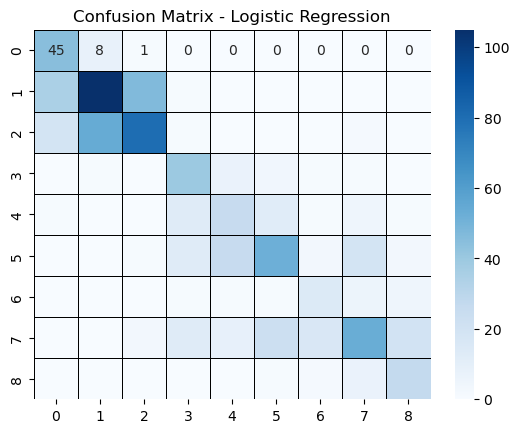

In [137]:
### Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5, linecolor="black")
plt.title("Confusion Matrix - Logistic Regression"); 

## Decision Tree Model

In [51]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)


DecisionTreeClassifier(random_state=42)

In [56]:
# Predictions
y_pred_dt = dt.predict(X_test)

print(f" Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

 Decision Tree Accuracy: 0.7313
Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.78      0.80        54
           2       0.80      0.77      0.79       188
           3       0.78      0.81      0.79       156
           4       0.63      0.76      0.69        54
           5       0.51      0.59      0.55        59
           6       0.61      0.62      0.62       117
           7       0.70      0.75      0.72        28
           8       0.80      0.67      0.73       137
           9       0.84      0.86      0.85        37

    accuracy                           0.73       830
   macro avg       0.72      0.74      0.73       830
weighted avg       0.74      0.73      0.73       830



##### Performance Overview
The Decision Tree shows strong overall performance with 73.13% accuracy sightly better tahn Logistic Regression of 53.25%.
Classes 1, 2, 3, 8 and 9 perform well with F1 scores above 0.73, indicating balanced precision and recall.

Classe 5 has the lowest F1 score(0.55) suggesting misclassification or overlap with similar classes.
Class 4 shows a good recall but lower precision meaning false positives are common.

Macro and Weighed average - Close values (0.73/0.73) suggests the model handles class imbalance well.

##### Geological Impact
Accurate prediction of dominant rock types (Classes 2,3,9) is important for identifying reservoir zones.

Missclassification in Class 5 might impact decisions in drilling or the resrvoir evaluation indicating potential lithological similarities or overlapping well log signatures.

##### Justification
It generally achieves 73.13% accuracy compared to Logistic regression of 53.25% making it more reliable for reservoir rock classification.
The Decision Tree capures complex non linear interactions between well log features better reflecting geological variablity and helps geologists in understanding why certain classifications are made.
By handling mixed data distributions and non linear splits the decision tree aligns well with the heterogeneous nature of subsurface formations.

## Hyperparameter Tuning for Decision Tree

In [98]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_dt = grid_search.best_estimator_
print(f" Best Decision Tree Model: {grid_search.best_params_}")

y_pred_dt = best_dt.predict(X_test)
print(f" Optimized Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

 Best Decision Tree Model: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
 Optimized Decision Tree Accuracy: 0.7361


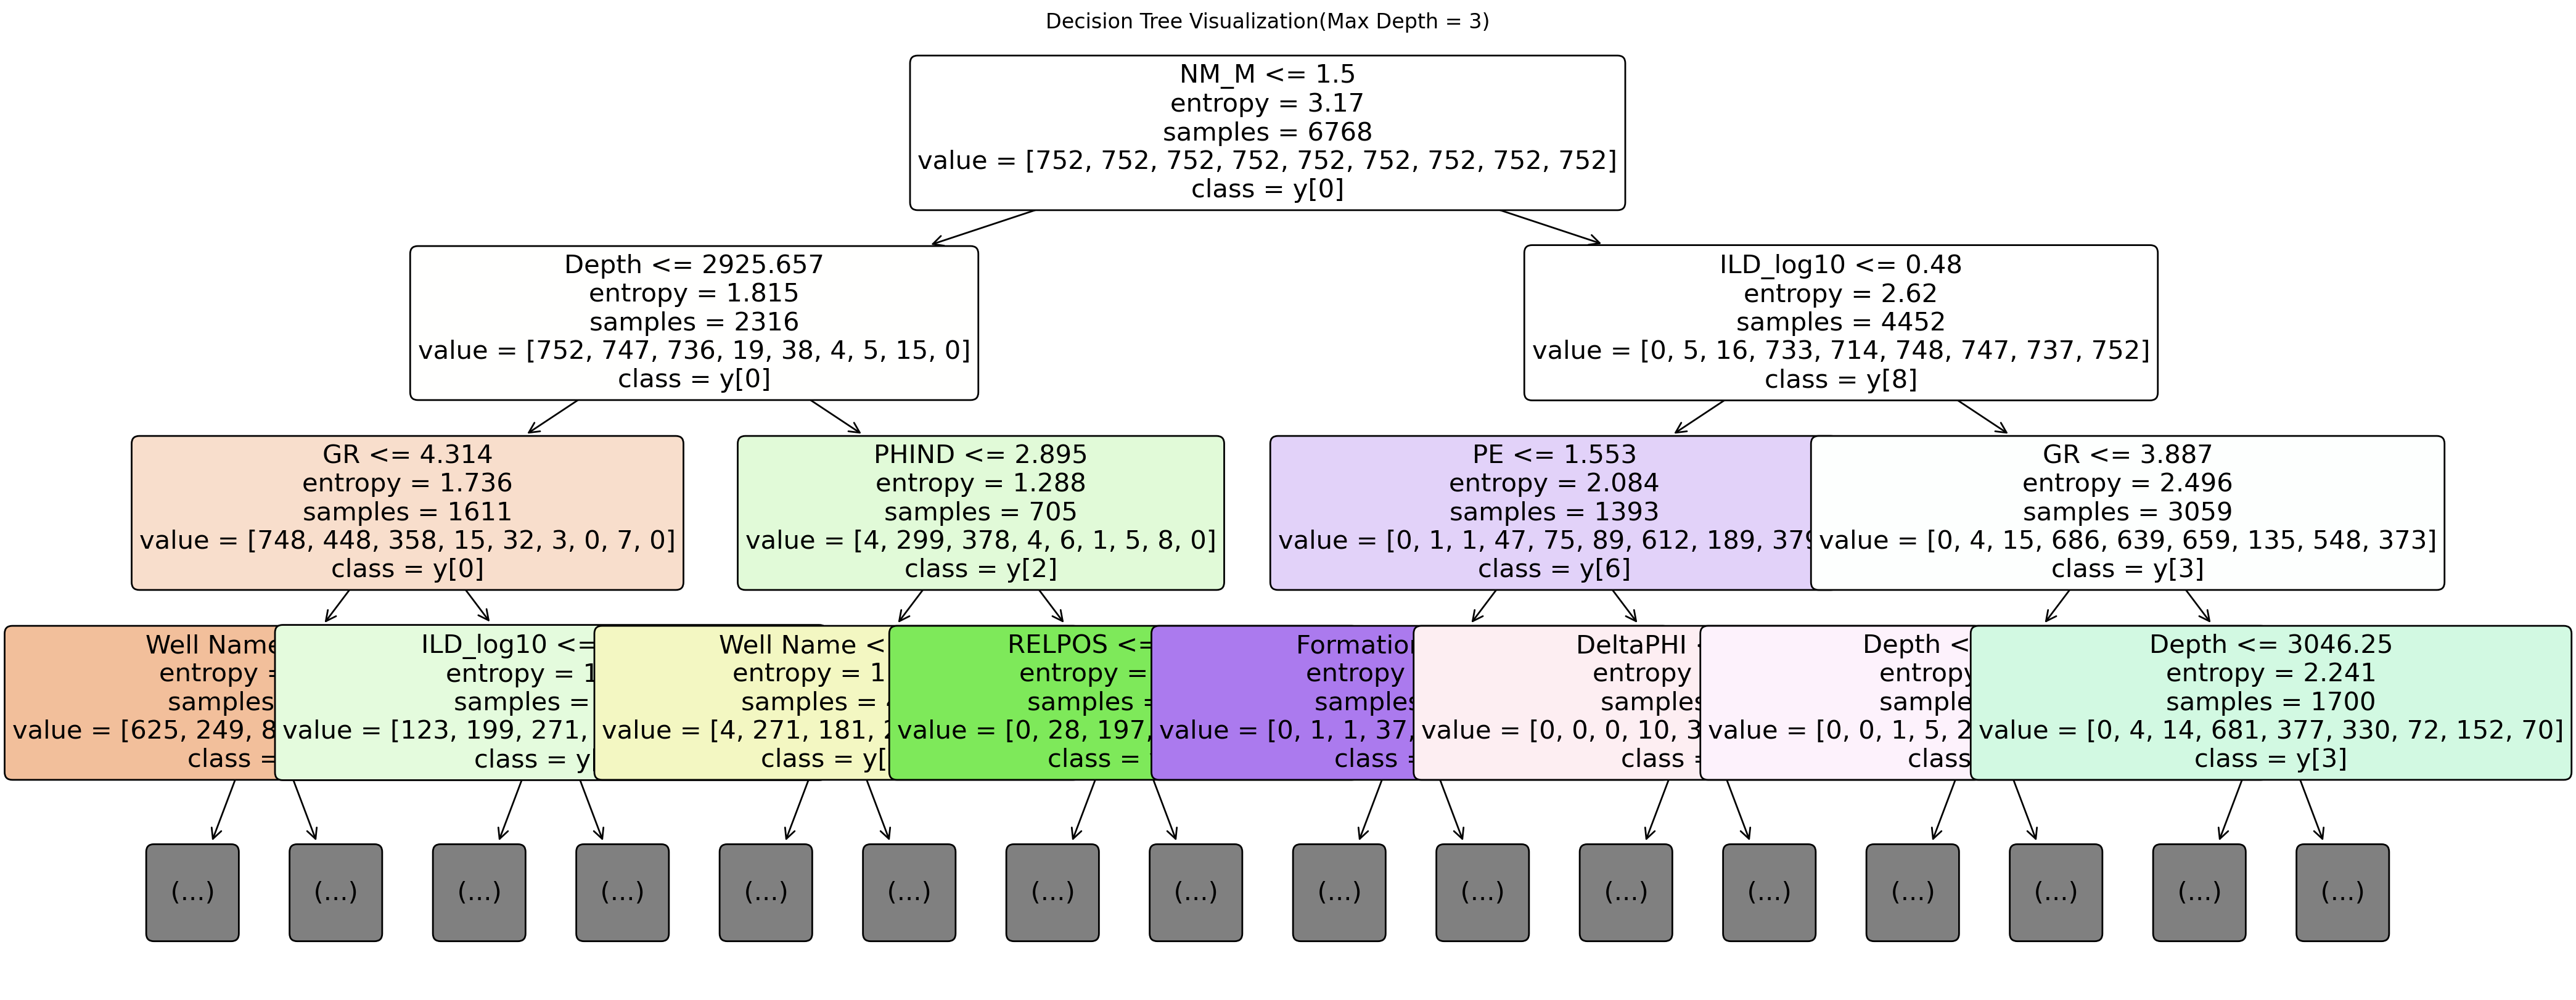

In [121]:
plt.figure(figsize=(24, 10), dpi=200)
plot_tree(best_dt, feature_names=X_train.columns, class_names=True, precision=3, filled=True, rounded=True, max_depth=3, fontsize=15)
plt.title("Decision Tree Visualization(Max Depth = 3)");

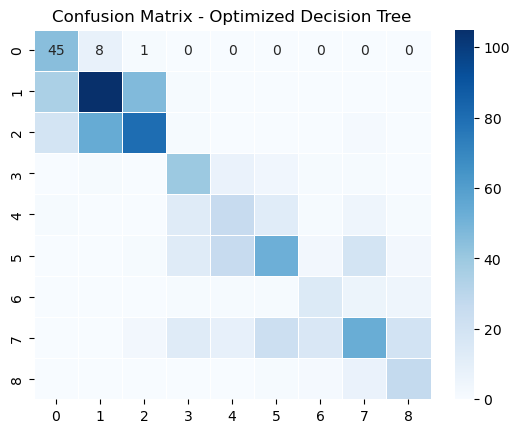

In [99]:
### Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - Optimized Decision Tree");

In [75]:
# Predictions of the best model
y_pred_best_dt = best_dt.predict(X_test)
 
    
#Evaluation
print(f"Tuned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_best_dt):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best_dt))

Tuned Decision Tree Accuracy: 0.7361
Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.83      0.84        54
           2       0.78      0.78      0.78       188
           3       0.79      0.79      0.79       156
           4       0.65      0.81      0.72        54
           5       0.59      0.69      0.64        59
           6       0.62      0.60      0.61       117
           7       0.70      0.68      0.69        28
           8       0.78      0.66      0.71       137
           9       0.76      0.86      0.81        37

    accuracy                           0.74       830
   macro avg       0.73      0.75      0.73       830
weighted avg       0.74      0.74      0.74       830



##### Performance Overview
The tuned Decision Tree got an accuracy of 73.61% which is an improvement of the initial model.
Hyperparameter tuning using entropy criterion,no depth mlimit, allowed the tree to capture more complex patterns in the data.

Strong Performing Classes:
Class 1(Precision:0.85, Recall:0.83) consistently predicted with high accuracy indicating clear differentiation in its features.
Class 3(Precision:0.79, Recall:0.79) Shows balance between precision and raeacll suggesting stable model predictions.
Class 9(Precision:0.76, Recall:0.86) High recall highlights the models ability to correctly identify most samples of this class.

Moderate Performing Classes:
Class 4(Precision:0.65, Recall:0.81) Improved recall indicates better sensitivity through precision suggests occasional misclassifications.
Class 5(Precision:0.59, Recall:0.69) While still lower performance, it shows improvement after tuning capturing more defining characteristics of this class.


Classes with balanced metrics
Class 2 and 8 maintain precision and recall indicating stable predictions, though refinement can still be done.

Macro avg(F1 score 0.73) indicates that the model handles all the clases fairly without bias towards the more frequent ones.
Weighed Avg(F1 score 0.74) slightly higher shows the model's overall good performance on the more represented classes.

##### Geological Impact
The Decision Tree key features supports reservoir rock type prediction helping in understanding lithological variations.
Classes with higher recall, Class 9 could represent distinct geological formations while misclassified samples may point transitional rock layer or complex lithologies.

##### Justification
The tuning has lead to more precise prediction 
Despite improved accuracy, Class 5 remaines inaccurate suggesting potential geological complexities.

To improve performance, especially for less predictable classes, applying Ensemble methods would help reduce variance and improve generalization.

## Random Forest

In [125]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [128]:
# Evaluation
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

Random Forest Accuracy: 0.8072


In [135]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=50, 
    cv=5, verbose=2, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


In [136]:
# Evaluate the best model
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Metrics
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8133
Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.81      0.89        54
           2       0.85      0.90      0.87       188
           3       0.88      0.86      0.87       156
           4       0.77      0.81      0.79        54
           5       0.76      0.66      0.71        59
           6       0.72      0.72      0.72       117
           7       0.85      0.79      0.81        28
           8       0.72      0.77      0.74       137
           9       0.94      0.89      0.92        37

    accuracy                           0.81       830
   macro avg       0.83      0.80      0.81       830
weighted avg       0.82      0.81      0.81       830



##### Perfrormance Overview
The Random Forest achieved an accuracy of 81.33% marking a significant improvement over both the Logistic Regression(53.25%) and Decision Tree(73.61%0
Its ensemble approach enhances generalization and reduced overfitting leading to more consistent results across all classes.

High Performing Classes
Class 1(Precision 0.98, F1 0.89) Etremely high precision though a slut dip in recall suggests missed samples.
Class 9(Precision 0.94, F1 0.92) Strong performance maintaining both high precision and recall indicating clear differentiation in its features.
Class 2 and 3 consistently performed well showing the model's ability to handle frequent classes.

Moderate Classes:
Class 5(F1 0.71) While improved from earlier models, it still lags slightly possibly due to overlapping geological features or fewer distinguishing attributes.
Class 6 and 8 have balanced metrics but the recall of class 6 suggests the model occassionally misses true postives.

Macro and Weighted Averages
Macro Avg(F1 0.81) Indicates fair treatment across all classes despite class sizes. 
Weighted Avg Shows strong overall performance considering the frequency of each class in the dataset.

##### Geological Impact
The high accuracy and consistency in the predictions anhance confidence in the geological interpretations especially in accurately classifying distinct reservoir rock types.
Strong results from Class 1 and 9 might indcate clearer lithological boundaries while mid range performers could represent more complex formations.

##### Justification
The Random Forest stands out as the best performing model with significant improvement in precision, recall and overall accuracy.
Its strength in handling non linear relationships makes it highly suitable for complex geological datasets.


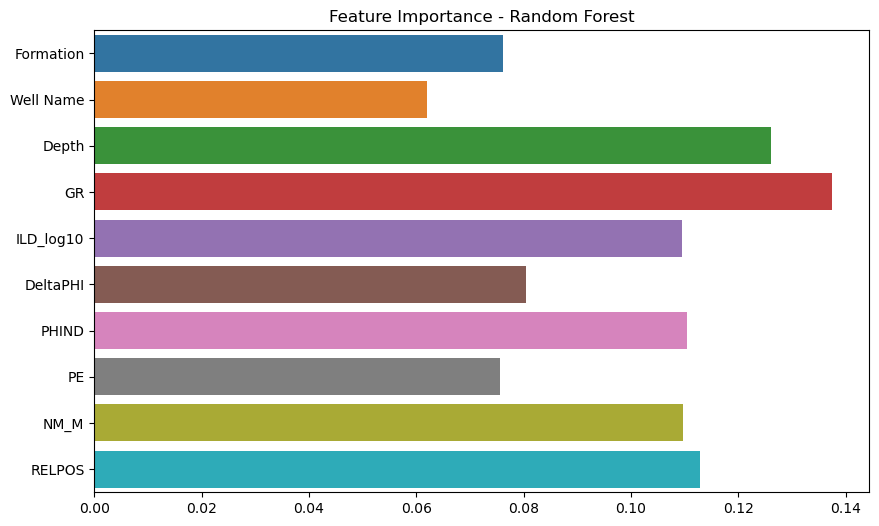

In [130]:
# Feature Importance for Random Forest
importances = rf.feature_importances_
features = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.show()

GR(Gamma ray) is the most influential aligning with geological practices where GR in differentiating lithologies.

Depth and NM_M also rank high, reflecting their role in capturing geological stratification and porosity.

Well Name holds minimal predictive power showing the model's ability to generalize across wells without relying on identifiers.

# MODEL EVALUATION

### Introduction
The goal of this project is to accurately predict reservoir rock facies using well log data, enabling better decision making in reservoir management and drilling operations.
The complexity of the geological data and class imbalance were addressed using SMOTE and advanced modeling techniques with Random Forest emerging as the top performing model.

**LogisticRegression** struggled with the complex geological patterns, leading to poor overall accuracy.

**Decision Tree** captured non linear relationships but showed mild overfitting.

**Random Forest** balanced accuracy, precision and recall making it the most reliable model for the task.